<a href="https://colab.research.google.com/github/helonayala/bab_datasets/blob/main/demo_video_sync.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video + Proprioceptive Sync Demo

This notebook demonstrates how to load proprioceptive signals and the synced video frames, then visually verify alignment.

- Load preprocessed input/output data (u, y)
- Load synced video frames using manual LED frame indices
- Inspect signals, sample frames, and interactive sync verification

## Install (if needed)

In [1]:
!pip install "bab_datasets[video,notebook] @ git+https://github.com/helonayala/bab_datasets.git"

  Cloning https://github.com/helonayala/bab_datasets.git to /tmp/pip-install-xlrv06f2/bab-datasets_ebc7279d57a140f2a8be98a0b8a09234
  Running command git clone --filter=blob:none --quiet https://github.com/helonayala/bab_datasets.git /tmp/pip-install-xlrv06f2/bab-datasets_ebc7279d57a140f2a8be98a0b8a09234
  Resolved https://github.com/helonayala/bab_datasets.git to commit ed5692dcb331bcf522b0677ea3c6cf3bb738f709
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import bab_datasets as nod

## Video directory

## Load preprocessed proprioceptive data

Load the dataset with preprocessing so the trigger is already aligned to t=0.

In [3]:
data = nod.load_experiment("swept_sine", preprocess=True)
data

InputOutputData "swept_sine" u.shape=(1100,) y.shape=(1100,)
sampling_time=0.0500 y_ref.shape=(1100,)

### Proprioceptive signals

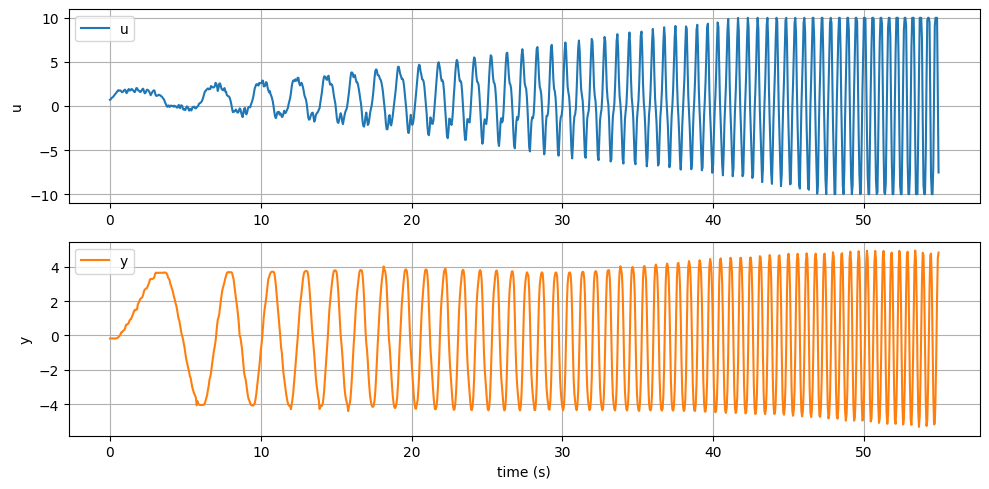

In [4]:
t = data.time_vector()
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, data.u, label='u')
plt.ylabel('u')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, data.y, label='y', color='tab:orange')
plt.ylabel('y')
plt.xlabel('time (s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Load synced video frames (aligned to trigger)

Load synced video frames. This uses the hardcoded LED frame map and aligns video_t to the trigger (t=0).

In [5]:
video_t, frames, sync = nod.load_synced_video_frames(
    video_name="swept_sine",
    data=data,
    preallocate=True,
    verbose=True,
)
video_t[:5], frames.shape

Loading video sync metadata...
Sync done. frame_start=291 sample_start=0 fps=30.002 sampling_time=0.050000
Loading frames 291..1941 (total 1650)
  loaded 165/1650 frames (10%)
  loaded 330/1650 frames (20%)
  loaded 495/1650 frames (30%)
  loaded 660/1650 frames (40%)
  loaded 825/1650 frames (50%)
  loaded 990/1650 frames (60%)
  loaded 1155/1650 frames (70%)
  loaded 1320/1650 frames (80%)
  loaded 1485/1650 frames (90%)
  loaded 1650/1650 frames (100%)
Loaded 1650 frames. video_t range 0.00s..54.96s
Done. frames.shape=(1650, 1080, 1920, 3)


(array([0.        , 0.03333098, 0.06666197, 0.09999295, 0.13332394]),
 (1650, 1080, 1920, 3))

### Video frames (sample)
Below are 4 evenly spaced frames from the synced video window.

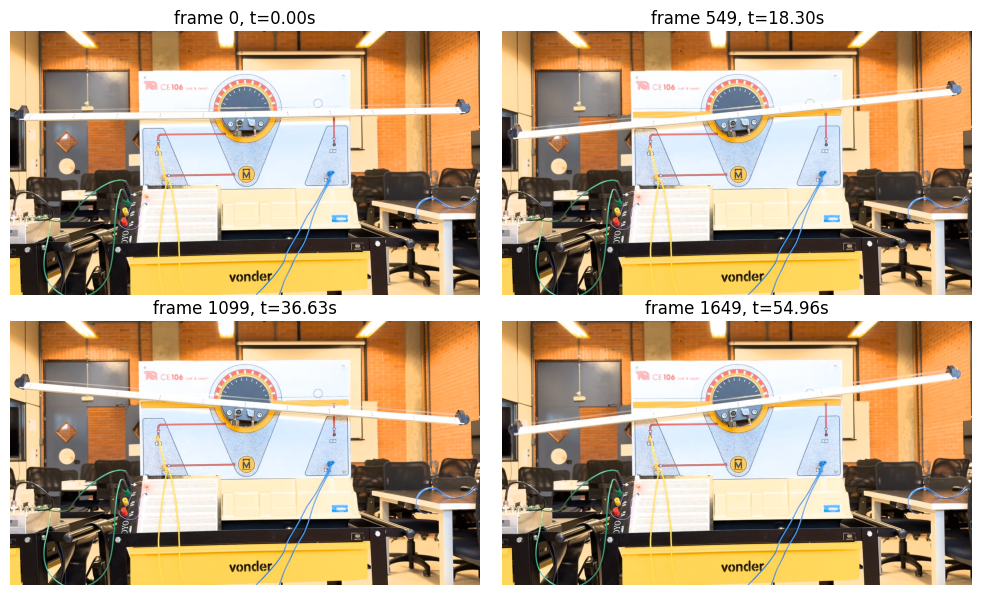

In [6]:
idx = np.linspace(0, len(frames) - 1, 4, dtype=int)
plt.figure(figsize=(10, 6))
for i, k in enumerate(idx, 1):
    plt.subplot(2, 2, i)
    plt.imshow(frames[k][:, :, ::-1])
    plt.title(f'frame {k}, t={video_t[k]:.2f}s')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Generate sync preview video

This creates an MP4 preview using the loaded frames and time vectors (no re-reading from disk).

In [7]:
preview_path = nod.make_sync_preview(
    frames=frames,
    video_t=video_t,
    data=data,
    out_path="/tmp/sync_preview.mp4",
    window_s=5.0,
    window_start=0.0,
)
preview_path

Rendering MP4:   0%|          | 0/151 [00:00<?, ?it/s]

'/tmp/sync_preview.mp4'

## Sync verification (interactive)
Use the slider to move through a 5s window and verify alignment visually.

In [8]:
import ipywidgets as widgets
from IPython.display import display

window_s = 20
window_start = 10
t0, t1 = window_start, window_start + window_s

t = data.time_vector()
mask = (t >= t0) & (t <= t1)
tw = t[mask] - t0
u_win = data.u[mask]
y_win = data.y[mask]

v_mask = (video_t >= t0) & (video_t <= t1)
vid_idx = np.where(v_mask)[0]

def show_at_slider(s):
    t_now = t0 + s
    i = vid_idx[np.argmin(np.abs(video_t[vid_idx] - t_now))]
    frame = frames[i]

    fig, ax = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [3, 2]})
    ax[0].imshow(frame[:, :, ::-1])
    ax[0].set_title(f't={s:.2f}s (window)')
    ax[0].axis('off')

    mask_cur = tw <= s
    ax[1].plot(tw[mask_cur], u_win[mask_cur], label='u', alpha=0.7)
    ax[1].plot(tw[mask_cur], y_win[mask_cur], label='y', alpha=0.7)
    ax[1].axvline(s, color='k', lw=1)
    ax[1].set_xlim(0, window_s)
    ax[1].set_xlabel('time (s)')
    ax[1].set_title('u / y (window)')
    ax[1].legend()
    ax[1].grid(True)
    plt.tight_layout()
    plt.show()

slider = widgets.FloatSlider(min=0.0, max=window_s, step=0.1, value=0.0, description='t(s)')
display(widgets.interact(show_at_slider, s=slider))

interactive(children=(FloatSlider(value=0.0, description='t(s)', max=20.0), Output()), _dom_classes=('widget-i…

<function __main__.show_at_slider(s)>